In [1]:
import sys 
quad_limit = 1000

nu_mass_ev = 0.06
from aemulusnu_massfunction.emulator_training import *
from aemulusnu_massfunction.fisher_utils import *
from aemulusnu_hmf import massfunction as hmf
from scipy.integrate import quad
fiducial_h = 0.6736


# #(Plank 2018 table 2. TT,TE,EE+lowE+lensing  + neutrino mass put in by hand)
fiducial_cosmology = {'10^9 As':2.1,
                      'ns': 0.9649,
                      'H0': 67.36,
                      'w0': -1,
                      'ombh2': 0.02237,
                      'omch2': 0.12,
                      'nu_mass_ev': nu_mass_ev,}



#(Same as above but put in DES Y3 OmegaM and Sigma8)
#print('DES Y3')
#Ωmh2 =  0.339*fiducial_h**2 # Y3 3x2pt
#Ωνh2 = nu_mass_ev/(93.14) #see astro-ph/0603494
##From the BBN seciton of DES Y3 paper
#Ωbh2 = 2.195/100
#Ωch2 = Ωmh2-Ωbh2-Ωνh2
#fiducial_cosmology = {'10^9 As': 1.520813,  #from σ8 for DES Y3 3x2 and convert_sigma8_to_As.ipynb
#                      'ns': 0.9649,
#                      'H0': 67.36,
#                      'w0': -1,
#                      'ombh2': Ωbh2,
#                      'omch2': Ωch2,
#                      'nu_mass_ev': nu_mass_ev,}

fiducial_cosmo_vals = get_cosmo_vals(fiducial_cosmology)
fiducial_ccl_cosmo = get_ccl_cosmology(tuple(fiducial_cosmo_vals))
fiducial_hmf_cosmology = hmf.cosmology(fiducial_cosmology)







z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]



print(fiducial_cosmology)


oup_cov_fname = 'fiducial_cluster_abundance_covariance_'

for key in fiducial_cosmology:
    ckey = key
    if key == '10^9 As':
        ckey = '1e9As'
    oup_cov_fname += '%s_%f_'%(ckey, fiducial_cosmology[key])

oup_cov_fname = list(oup_cov_fname)

for i,char in enumerate(oup_cov_fname):
    if(char == '.'):
        oup_cov_fname[i] = 'p'

oup_cov_fname = oup_cov_fname[:-1]

oup_cov_fname = ''.join(oup_cov_fname)
oup_cov_fname += '.pkl'
print('outputting cov to', oup_cov_fname)



# N_fiducial = N_in_z_bins_and_richness_bins(fiducial_cosmology, richness_bin_edges, z_bin_edges)


import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11






cluster_count_cov = np.zeros((len(z_bin_edges) - 1, len(z_bin_edges) - 1, len(richness_bin_edges) - 1, len(richness_bin_edges) - 1))


halo_bias = ccl.halos.HaloBiasTinker10()


from classy import Class

h = fiducial_cosmology['H0']/100
cosmo_dict = {
    'h': h,
    'Omega_b': fiducial_cosmology['ombh2'] / h**2,
    'Omega_cdm': fiducial_cosmology['omch2'] / h**2,
    'N_ur': 0.00641,
    'N_ncdm': 1,
    'output': 'mPk mTk',
    'z_pk': '0.0,99',
    'P_k_max_h/Mpc': 20.,
    'm_ncdm': fiducial_cosmology['nu_mass_ev']/3,
    'deg_ncdm': 3,
    'T_cmb': 2.7255,
    'A_s': fiducial_cosmology['10^9 As'] * 10**-9,
    'n_s': fiducial_cosmology['ns'],
    'Omega_Lambda': 0.0,
    'w0_fld': fiducial_cosmology['w0'],
    'wa_fld': 0.0,
    'cs2_fld': 1.0,
    'fluid_equation_of_state': "CLP"
}

#get logsigma spline
z = np.linspace(0, 2, 100)

pkclass = Class()
pkclass.set(cosmo_dict)
pkclass.compute()


from scipy.interpolate import InterpolatedUnivariateSpline

def compute_chi_integrand(z_val):
    Ωb =  fiducial_cosmology['ombh2'] / h**2
    Ωc =  fiducial_cosmology['omch2'] / h**2
    Ez = np.sqrt((Ωb+Ωc)*(1+z_val)**3 + (1-(Ωb+Ωc))) # unitless
    return DH/Ez #units of distance h^-1 Mpc
def compute_chi(z_val):
    chi, _ = quad(compute_chi_integrand, 0, z_val, epsabs=0, epsrel=5e-3)#units of h^-1 Mpc
    return chi


z_values = np.linspace(0, 2, 500)  # Create an array of z values (adjust range and number of points as needed)
chi_values = [compute_chi(z) for z in z_values]
chi_spline = InterpolatedUnivariateSpline(z_values, chi_values)



from scipy.integrate import quad, dblquad, nquad
from scipy.special import jv 


from functools import cache


θs = np.sqrt(Ωs_rad / np.pi)

@cache
def variance_integral(kperp1, kperp2, z_val):
    kperp = np.sqrt(kperp1**2 + kperp2**2) #units of h / Mpc
    #kperp*h has units 1 / Mpc
    Plin = pkclass.pk_lin(kperp*h, np.array([z_val]))*h**3 #units of Mpc^3/h^3 
    chi = chi_spline(z_val)
    arg = 2*jv(1, kperp*chi*θs) / (kperp*chi*θs) #unitless
    return Plin * arg**2 / (2*np.pi)**2 #units of Mpc^3/h^3 ~ distance^3


@cache
def inner_integral(lam, M, z_val):
    p = cluster_richness_relation(M, lam, z_val)
    dn_dM = emulator(fiducial_hmf_cosmology, M, redshiftToScale(z_val))  # h^4 / Mpc^3 Msun

    bh = halo_bias(fiducial_ccl_cosmo, M / fiducial_h, 1./(1+z_val))
    return p * dn_dM  * bh

    

MAX_K = 10
options={'limit':quad_limit, 'epsrel': 5e-3, 'epsabs': 0}
options_easy={'limit':50, 'epsrel': 5e-3, 'epsabs': 0}

def outer_integral(z_val, lam_alpha_min, lam_alpha_max, lam_beta_min, lam_beta_max):
    integral_M_val, abserr1 = nquad(inner_integral, [[lam_alpha_min, lam_alpha_max], [M_min*fiducial_ccl_cosmo['h'], M_max*fiducial_ccl_cosmo['h']]],
                             args=(z_val,), opts=[options_easy, options_easy],)
#    assert(np.abs(abserr1/integral_M_val) < 5e-3 ) # less than 1%

    integral_M_prime_val, abserr2 = nquad(inner_integral, [[lam_beta_min, lam_beta_max], [M_min*fiducial_ccl_cosmo['h'], M_max*fiducial_ccl_cosmo['h']]],
                             args=(z_val,), opts=[options_easy, options_easy],)
#    assert(np.abs(abserr2/integral_M_prime_val) < 5e-3)

    
    d2V_dzdOmega = comoving_volume_elements(z_val, cosmo=fiducial_ccl_cosmo)
    h = fiducial_cosmology['H0']/100
    Ωb =  fiducial_cosmology['ombh2'] / h**2
    Ωc =  fiducial_cosmology['omch2'] / h**2

    Ez = np.sqrt((Ωb+Ωc)*(1+z_val)**3 + (1-(Ωb+Ωc))) # unitless
    
    variance, abserr3 = nquad(variance_integral, [[0, MAX_K], [0, MAX_K]], 
                              opts = [options, options],
                              args=(z_val,), )
#    assert(np.abs(abserr3/variance) < 5e-3)


    return Ωs_rad**2 * integral_M_val * integral_M_prime_val * d2V_dzdOmega**2 * Ez/DH * variance


{'10^9 As': 2.1, 'ns': 0.9649, 'H0': 67.36, 'w0': -1, 'ombh2': 0.02237, 'omch2': 0.12, 'nu_mass_ev': 0.06}
outputting cov to fiducial_cluster_abundance_covariance_1e9As_2p100000_ns_0p964900_H0_67p360000_w0_-1p000000_ombh2_0p022370_omch2_0p120000_nu_mass_ev_0p060000.pkl


In [2]:
richness_bin_edges

[20.0, 30.0, 45.0, 60.0, 300.0]

In [3]:
z_bin_edges

[0.2, 0.4, 0.6, 0.8, 1.0]

In [75]:
options_easy={'limit':50, 'epsrel': 1e-3, 'epsabs': 0}
from scipy.interpolate import interp1d

f_inner_integral = {}
for l_min, l_max in zip(richness_bin_edges, richness_bin_edges[1:]):
    z_vals = np.linspace(0.2, 1.0, 100)
    res = []
    for z_val in tqdm(z_vals):
        tmp, err = nquad(inner_integral, [[l_min, l_max], [M_min*fiducial_ccl_cosmo['h'], M_max*fiducial_ccl_cosmo['h']]],
                                 args=(z_val,), opts=[options_easy, options_easy],)
        res += [tmp]
    f_inner_integral[(l_min, l_max)] = interp1d(x = z_vals, y = res)

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


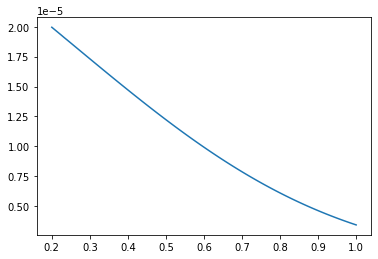

In [77]:
plt.plot(z_vals, f_inner_integral[(20.0, 30.0)](z_vals))

In [5]:
f_inner_integral

{(20.0, 30.0): <scipy.interpolate._interpolate.interp1d at 0x7f819848e6d0>,
 (30.0, 45.0): <scipy.interpolate._interpolate.interp1d at 0x7f819a02a360>,
 (45.0, 60.0): <scipy.interpolate._interpolate.interp1d at 0x7f819848e7c0>,
 (60.0, 300.0): <scipy.interpolate._interpolate.interp1d at 0x7f819848e770>}

In [6]:
def integrand_hard(lkperp, z_val=0.6):
    kperp = np.exp(lkperp)
    Plin = pkclass.pk_lin(kperp*h, np.array([z_val]))*h**3 #units of Mpc^3/h^3 
    chi = chi_spline(z_val)
    arg = 2*jv(1, kperp*chi*θs) / (kperp*chi*θs) #unitless
    return Plin * arg**2 / (2*np.pi)**2 

In [ ]:
def integrand_hard(lkperp, z_val=0.6):
    kperp = np.exp(lkperp)
    Plin = pkclass.pk_lin(kperp*h, np.array([z_val]))*h**3 #units of Mpc^3/h^3 
    chi = chi_spline(z_val)
    arg = 2*jv(1, kperp*chi*θs) / (kperp*chi*θs) #unitless
    return Plin * arg**2 / (2*np.pi)**2 

In [7]:
2**13

8192

/tmp/ipykernel_32152/4008449645.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Plin = pkclass.pk_lin(kperp*h, np.array([z_val]))*h**3 #units of Mpc^3/h^3


[]

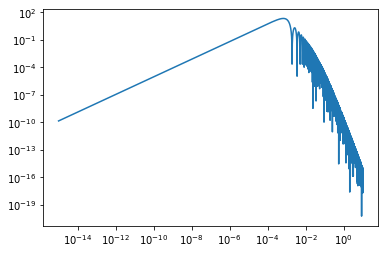

In [38]:
kperp_samples = np.geomspace(1e-15, MAX_K, 2**13)
y =  [integrand_hard(np.log(kperp_curr)) for kperp_curr in kperp_samples]
plt.plot(kperp_samples,y)
plt.loglog()

In [39]:
# ok yeah this is probably best done with trapezoidal, quad is never gonna converge for this
# advice from Manu: trapezoidal maybe safer for super oscillatory integrals because simpsons is 
# high order and maybe too clever for highly oscillatory stuff

In [40]:
# following https://github.com/LSSTDESC/CCL/blob/9b1a2cd7d5c036b41305f059ba18e7e0e181572e/pyccl/tests/test_covariances.py#L124 
# to do integral in logk
# makes sense, look at above plot of the integrand

In [41]:
def variance_integrand_logk(lkperp, z_val):
    #this is integrated against dlnk 
    kperp = np.exp(lkperp) #units of h / Mpc
    
    chi = chi_spline(z_val)
    R = chi * θs
    x = kperp * R
    W = 2*jv(1, x) / (x) #unitless
    
    #kperp*h has units 1 / Mpc
    Plin = fiducial_hmf_cosmology.pkclass.pk_lin(kperp*h, np.array([z_val]))*h**3 #units of Mpc^3/h^3 

    return Plin * W**2 * kperp**2 / (2*np.pi) #units of Mpc/h 

In [42]:
2**8

256

In [43]:
MAX_K

10

In [66]:
from scipy.integrate import trapezoid, simpson
nkperp_samples = int(2**14)
lkperp_arr =  np.log(np.geomspace(1e-15, MAX_K, (nkperp_samples)))
z_samples_var = np.linspace(0.2, 1.0, 100)
vars_trapz = []
vars_simps = []
for z_val in tqdm(z_samples_var):

    variance_integrand = np.zeros((nkperp_samples))

    for i in range(len(lkperp_arr)):
        variance_integrand[i] = variance_integrand_logk(lkperp_arr[i], z_val = z_val)

    variance = trapezoid(variance_integrand, x=lkperp_arr)
    vars_trapz += [variance]
    
    variance_simpson = simpson(variance_integrand, x=lkperp_arr)
    vars_simps += [variance_simpson]
    
vars_trapz = np.array(vars_trapz)
vars_simps = np.array(vars_simps)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_32152/633064051.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Plin = fiducial_hmf_cosmology.pkclass.pk_lin(kperp*h, np.array([z_val]))*h**3 #units of Mpc^3/h^3
100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


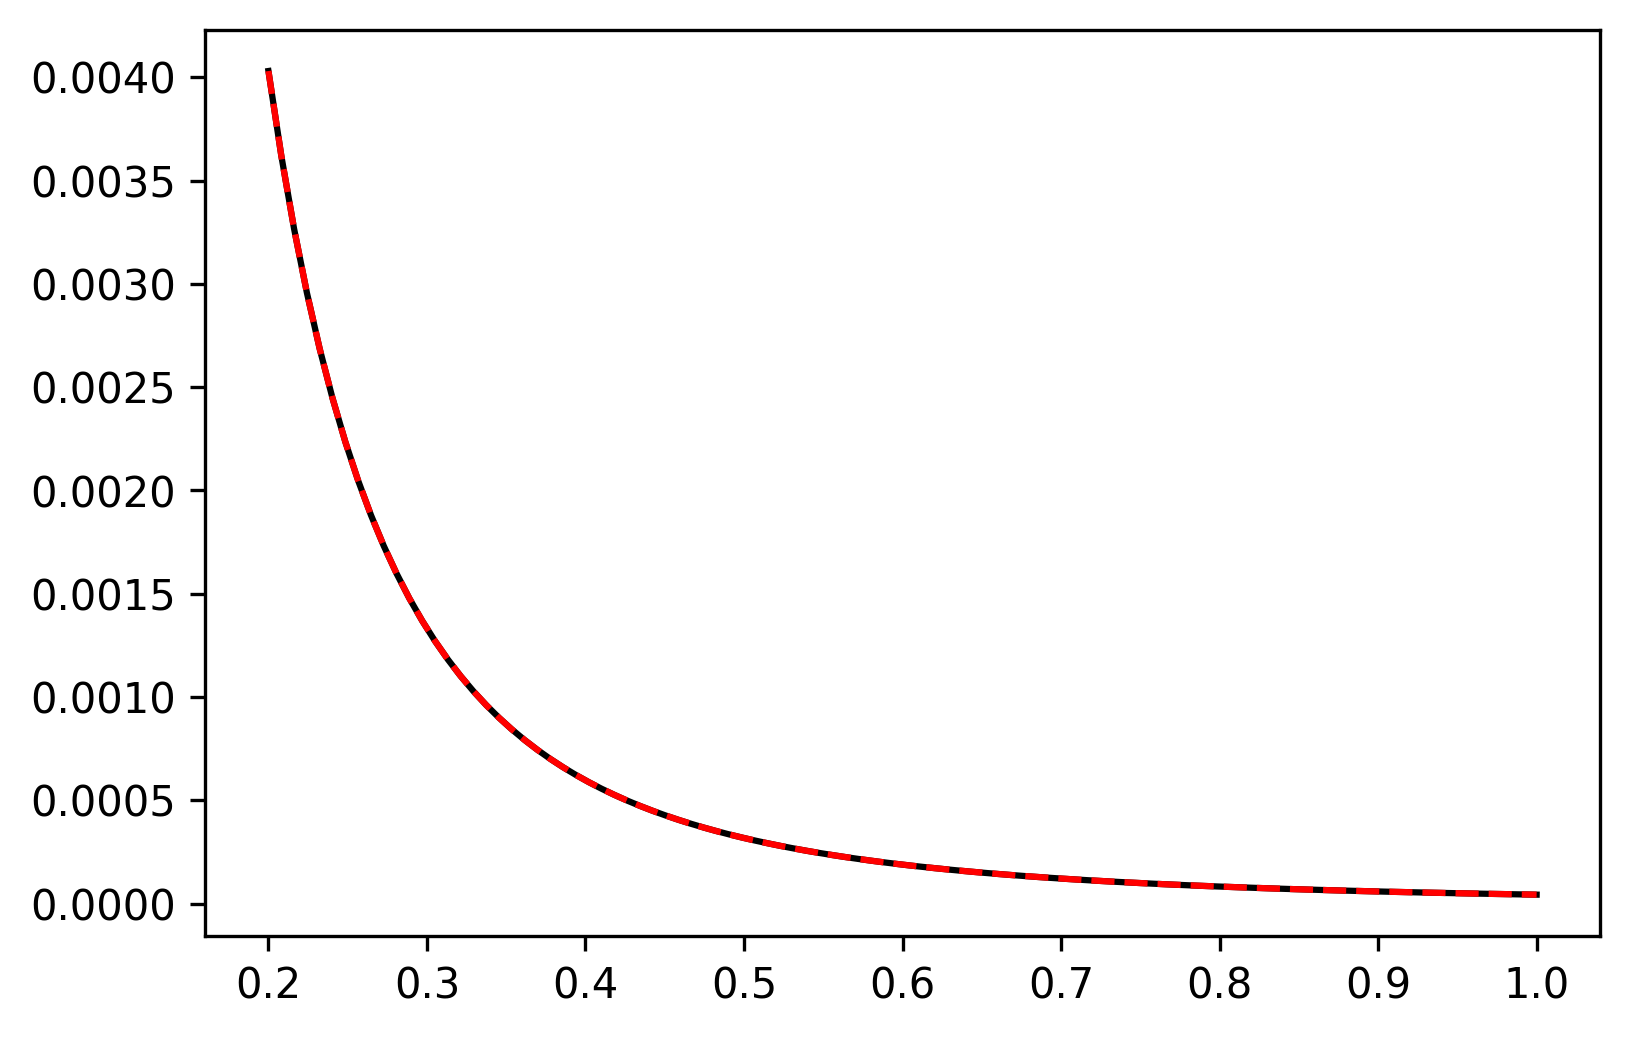

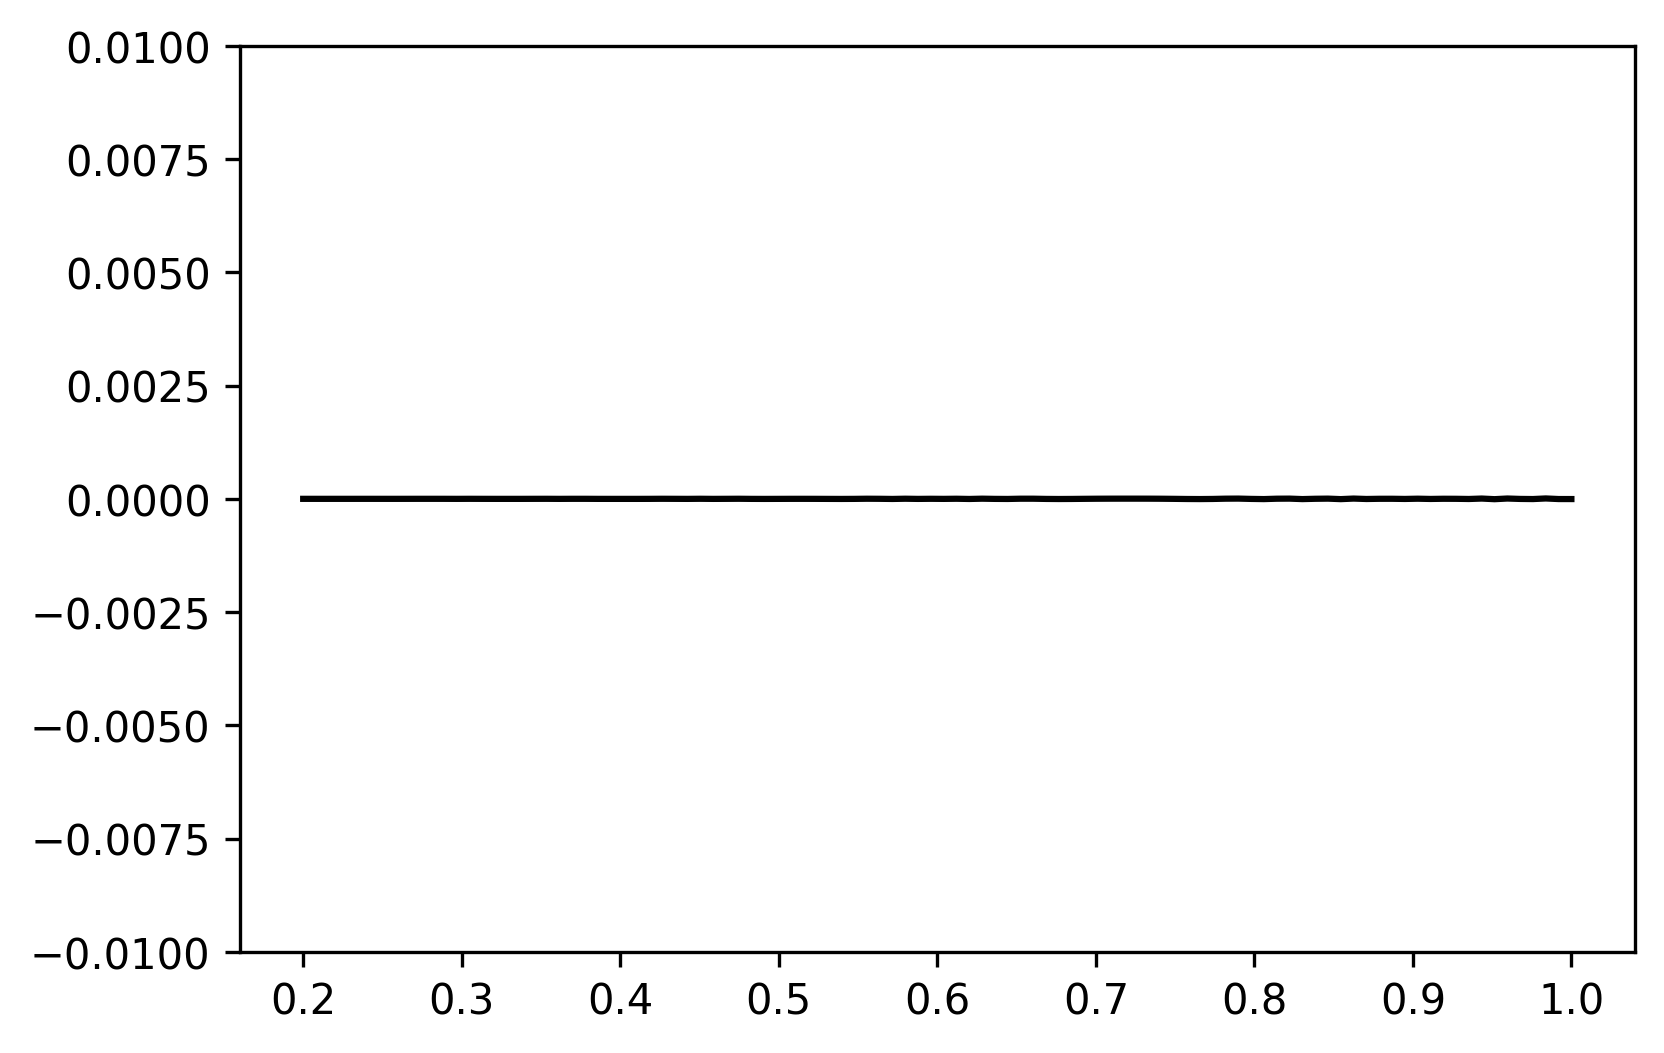

In [67]:
plt.figure(dpi=300)
plt.plot(z_samples_var, vars_trapz, 'k')
plt.plot(z_samples_var, vars_simps, 'r--')
plt.show()

plt.figure(dpi=300)
plt.plot(z_samples_var, (vars_trapz-vars_simps)/vars_simps, 'k')
plt.ylim(-0.01, 0.01)
plt.show()

In [68]:
interp1d

scipy.interpolate._interpolate.interp1d

In [70]:
f_variance = interp1d(x=z_samples_var, y=vars_trapz)

In [71]:
with open('asdf.pkl', 'wb') as f:
    pickle.dump(f_variance, f)

In [72]:
f_var_computed = -1
with open('f_variance_integrals_1e9As_2p100000_ns_0p964900_H0_67p360000_w0_-1p000000_ombh2_0p022370_omch2_0p120000_nu_mass_ev_0p060000.pkl', 'rb') as f:
    f_var_computed = pickle.load(f)

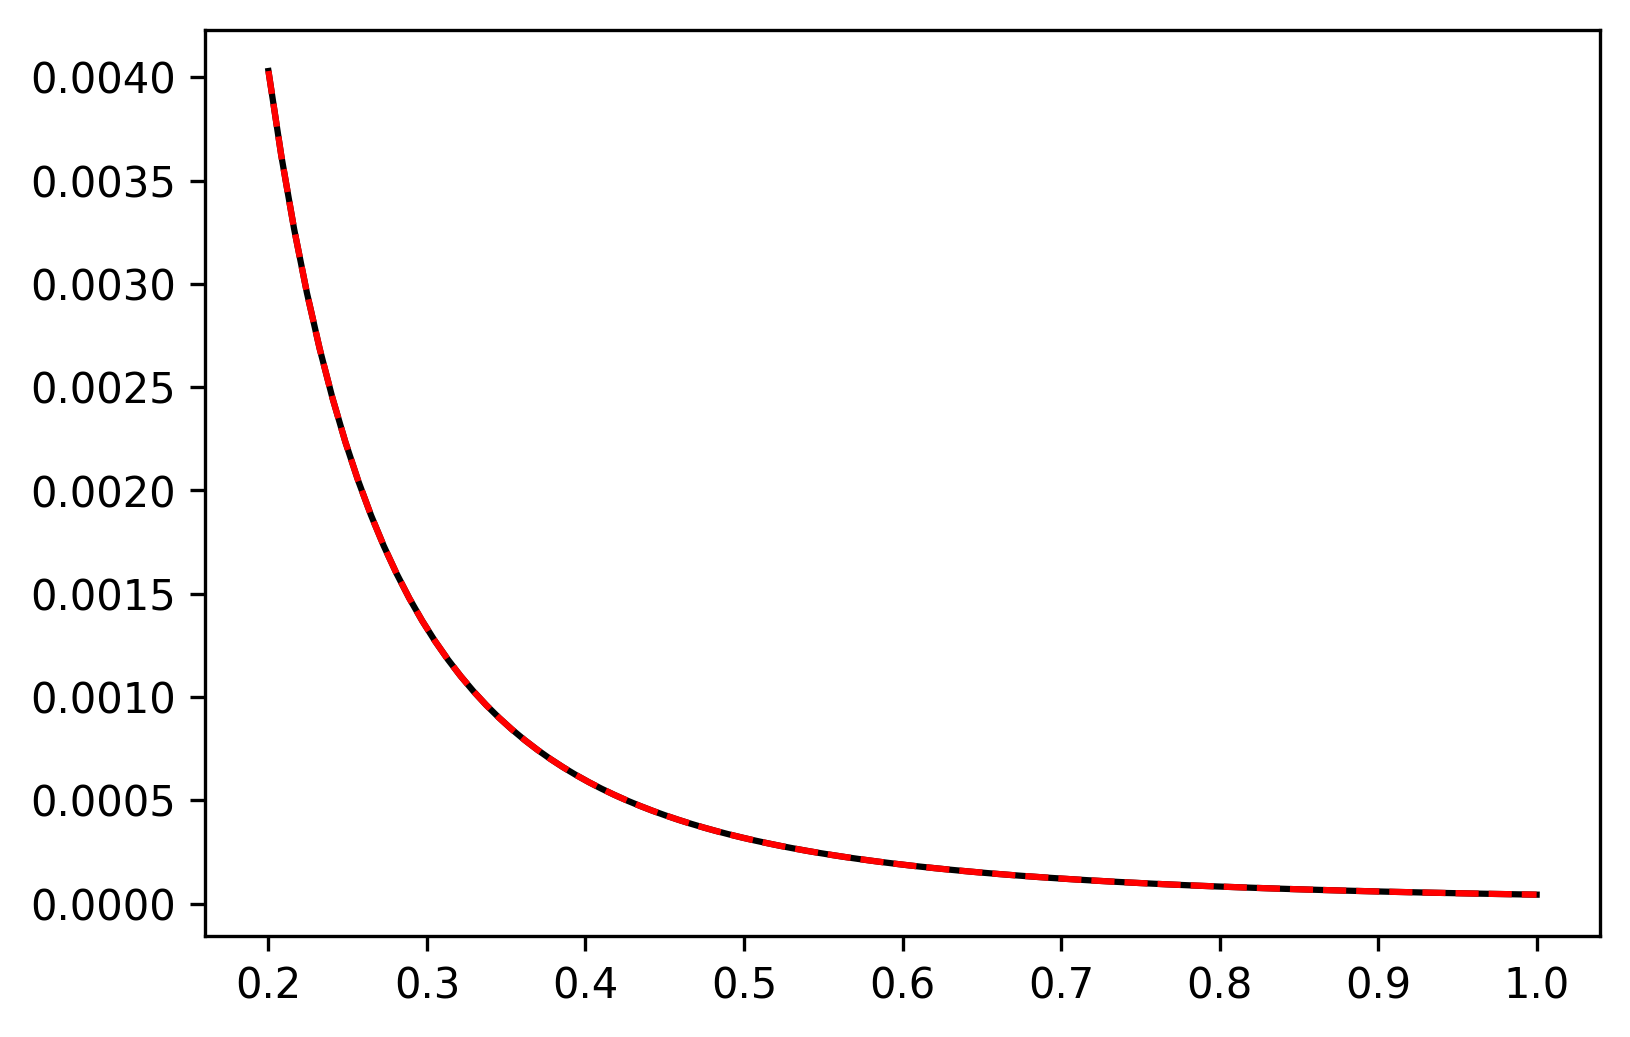

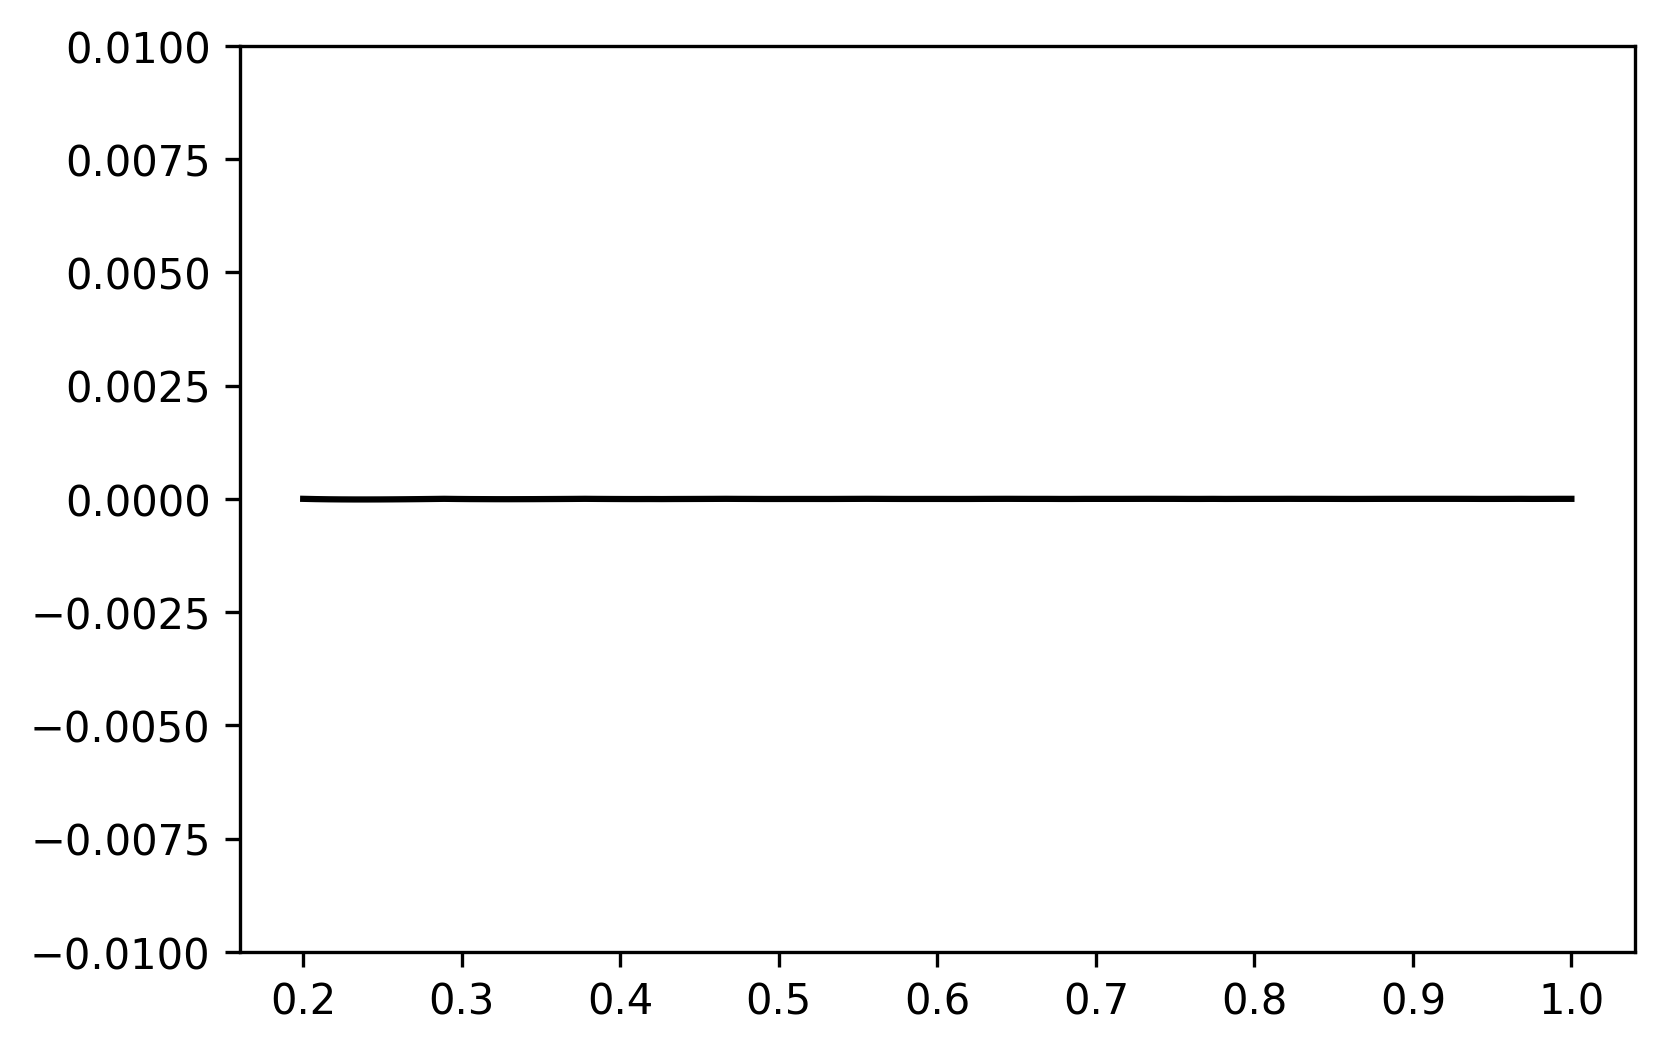

In [73]:
plt.figure(dpi=300)
plt.plot(z_samples_var, vars_trapz, 'k')
plt.plot(z_samples_var, f_var_computed(z_samples_var), 'r--')
plt.show()

plt.figure(dpi=300)
plt.plot(z_samples_var, (vars_trapz-f_var_computed(z_samples_var))/vars_simps, 'k')
plt.ylim(-0.01, 0.01)
plt.show()